# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 23.04.2024

Мягкий дедлайн: 13.05.2024 23:59 MSK

Жесткий дедлайн: 18.05.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [3]:
# %%bash
# kaggle datasets download -d mlg-ulb/creditcardfraud
# unzip creditcardfraud.zip

In [4]:
df = pd.read_csv('/Users/vsevolodparamonov/Downloads/creditcard.csv')

Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

Доля положительного класса: 0.001727485630620034


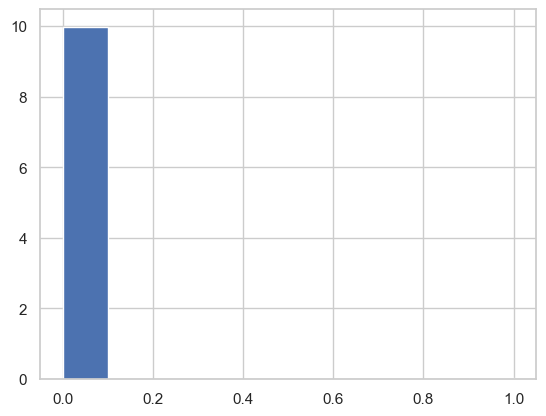

In [5]:
plt.hist(df['Class'], density=True);
print(f'Доля положительного класса: {df.Class.mean()}')

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [6]:
df['Hour'] = df['Time'] // 3600
df['Day'] = df['Hour'] // 24
df['Hour'] %= 24

df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Day
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,23.0,1.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,23.0,1.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,23.0,1.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,23.0,1.0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0,23.0,1.0


> #### Последнему наблюдению соответсвует <code>Hour</code> 47 и <code>Days</code> 1 $\Rightarrow$ данные покрывают 2 дня

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

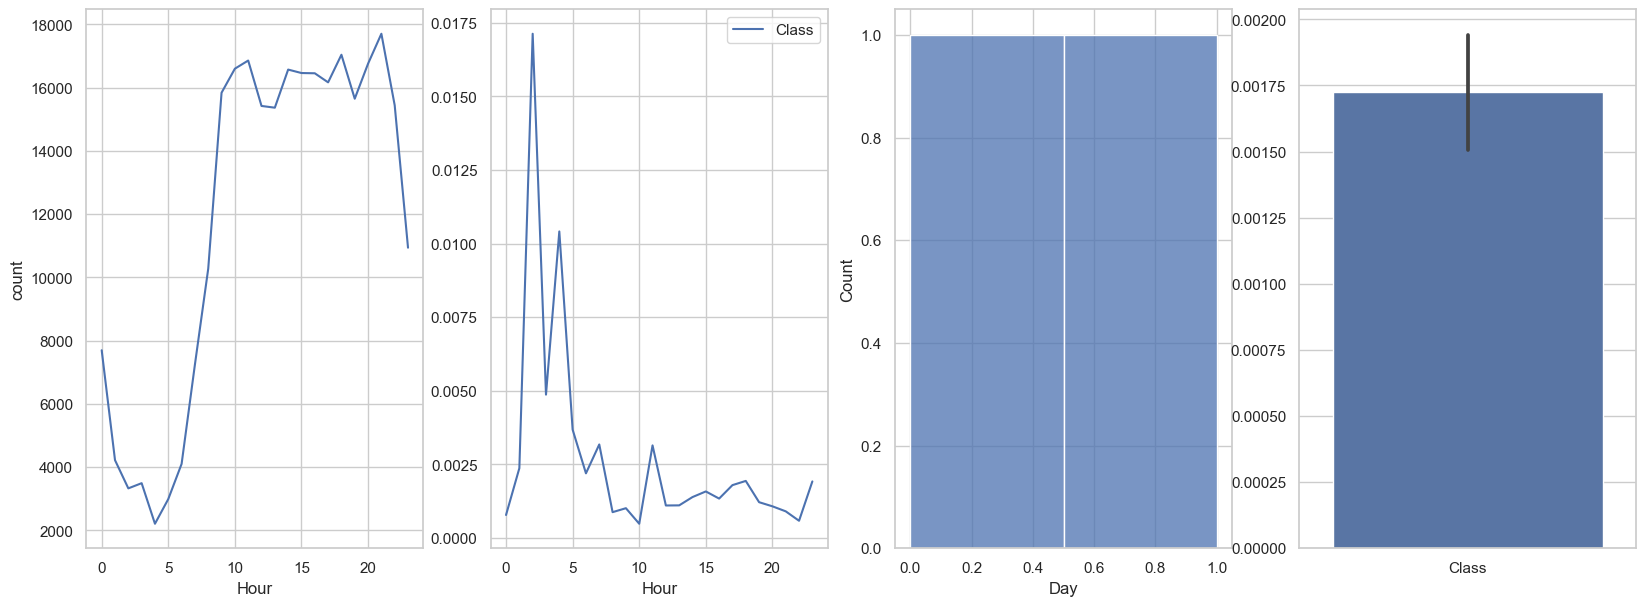

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7))

sns.lineplot(df['Hour'].value_counts().sort_index(), ax=ax[0])
sns.lineplot(df.groupby('Hour').agg({'Class': 'mean'}), ax=ax[1])
sns.histplot(df['Day'].value_counts().sort_index(), x = 'Day', ax=ax[2])
sns.barplot(df.groupby('Day').agg({'Class': 'mean'}), ax=ax[3]);

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

> #### Существует частный случай корреляции Пирсона, который помогает выявить степень линейной взаимосвязи между бинарной и вещественной переменными
>
> #### С помощью <code>pointbiserialr</code> посчитаем наблюдаемую статистику, а также <code>p-value</code> и отобразим топ 6 признаков, которые коррелируют с целевой переменной

In [7]:
from scipy import stats

corrs = pd.DataFrame()

corrs = pd.concat([corrs, df.apply(lambda x: stats.pointbiserialr(df['Class'], x)[0])], axis=1)
corrs = pd.concat([corrs, df.apply(lambda x: stats.pointbiserialr(df['Class'], x)[1])], axis=1)
corrs.columns = ['Statistic', 'P-value']
corrs['Reject_H0?'] = corrs['P-value'].apply(lambda x: 'YES' if x < 0.05 else 'NO')
corrs = corrs.sort_values('Statistic', ascending=False).iloc[1:7]
corrs

,Statistic,P-value,Reject_H0?
V11,0.154876,0.000000e+00,YES
V4,0.133447,0.000000e+00,YES
V2,0.091289,0.000000e+00,YES
V21,0.040413,3.002269e-103,YES
V19,0.034783,5.801517e-77,YES
V20,0.020090,7.964292e-27,YES


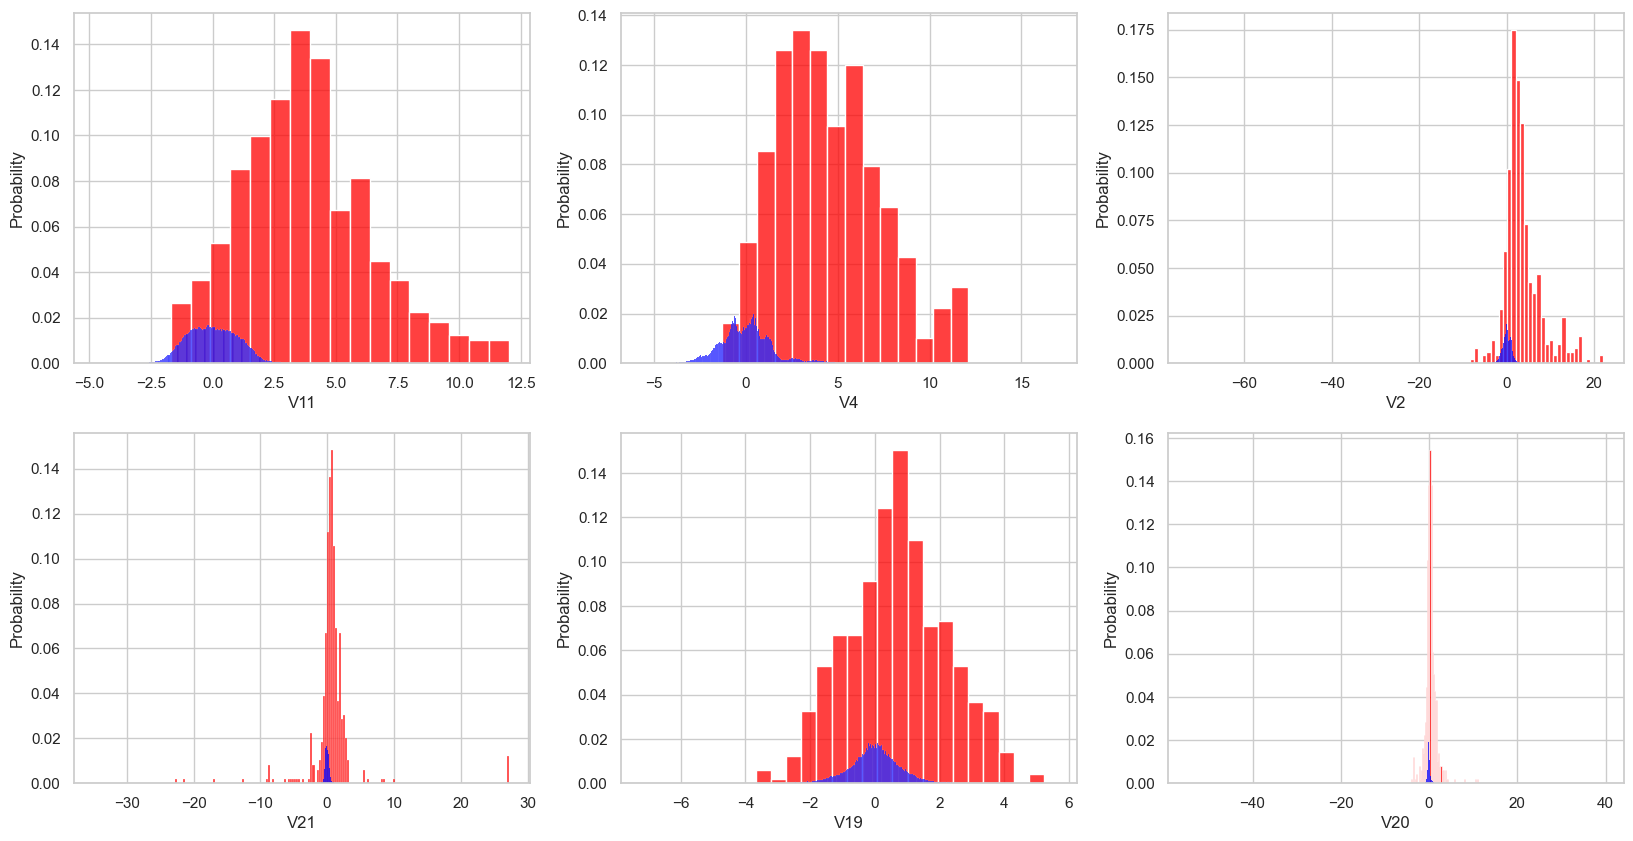

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

def plot_distrib(var, ax):

    sns.histplot(df[df['Class'] == 1], x=var, color='red', ax=ax, stat='probability')
    sns.histplot(df[df['Class'] == 0], x=var, color='blue', ax=ax, stat='probability')

for i in range(6):

    plot_distrib(corrs.index[i], ax[i // 3][i % 3])


Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [9]:
df_train, df_test = df.iloc[:int(df.shape[0] * 0.8) ,:], df.iloc[int(df.shape[0] * 0.8) : ,:]

df_val, df_test = df_test.iloc[:int(df_test.shape[0] * 0.5), :], df_test.iloc[int(df_test.shape[0] * 0.5) : , :]

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print(f'Accuracy: {accuracy_score(df_test["Class"], np.full(df_test.shape[0], 0))}')

Accuracy: 0.9992275552122467


Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [11]:
def kappa(y_true, y_pred):

    p_0 = accuracy_score(y_true, y_pred)

    p_e_1 = (sum(y_true == 1) / y_true.shape[0]) * (sum(y_pred == 1) / y_pred.shape[0])
    p_e_2 = (sum(y_true == 0) / y_true.shape[0]) * (sum(y_pred == 0) / y_pred.shape[0])

    p_e = p_e_1 + p_e_2

    return (p_0 - p_e) / (1 - p_e)

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [12]:
def mcc(y_true, y_pred):

    conf = pd.DataFrame([y_pred, y_true]).T
    conf.columns = ['y_pred', 'y_true']

    TP = conf[(conf['y_pred'] == 1) & (conf['y_true'] == 1)].shape[0]
    TN = conf[(conf['y_pred'] == 0) & (conf['y_true'] == 0)].shape[0]
    FP = conf[(conf['y_pred'] == 0) & (conf['y_true'] == 1)].shape[0]
    FN = conf[(conf['y_pred'] == 1) & (conf['y_true'] == 0)].shape[0]

    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))

    return mcc if np.isnan(mcc) == False else 0

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [13]:
pred_naive = np.full(df_test.shape[0], 0)

print(f'Коэффициент Каппа Коэна: {kappa(df_test["Class"].values, pred_naive)}')
print(f'MCC: {mcc(df_test["Class"].values, pred_naive)}')

Коэффициент Каппа Коэна: 0.0
MCC: 0


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [14]:
from catboost import CatBoostClassifier

In [15]:
cb = CatBoostClassifier(verbose=False).fit(df_train.drop('Class', axis=1), df_train['Class'])
cb_pred_test = cb.predict_proba(df_test.drop('Class', axis=1))[:, 1]
cb_pred_val = cb.predict_proba(df_val.drop('Class', axis=1))[:, 1]


print(f'Коэффициент Каппа Коэна на test: {kappa(df_test["Class"].values, cb_pred_test >= 0.5)}')
print(f'MCC на test: {mcc(df_test["Class"].values, cb_pred_test >= 0.5)}')
print(f'PR-AUC на test: {average_precision_score(df_test["Class"].values, cb_pred_test)}', '\n')


print(f'Коэффициент Каппа Коэна на val: {kappa(df_val["Class"].values, cb_pred_val >= 0.5)}')
print(f'MCC на val: {mcc(df_val["Class"].values, cb_pred_val >= 0.5)}')
print(f'PR-AUC на val: {average_precision_score(df_val["Class"].values, cb_pred_val)}', '\n')

Коэффициент Каппа Коэна на test: 0.7366708149419411
MCC на test: 0.7460414610269303
PR-AUC на test: 0.6993629115076488 

Коэффициент Каппа Коэна на val: 0.821949793855346
MCC на val: 0.8352966615113866
PR-AUC на val: 0.848430326450942 



Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [16]:
from sklearn.utils.class_weight import compute_class_weight

cw = {0: 1, 1: (df_train['Class'] == 0).sum()/(df_train['Class'] == 1).sum()}

clf = CatBoostClassifier(class_weights=cw, verbose=False).fit(df_train.drop('Class', axis=1), df_train['Class'])

cb_pred_test_2 = clf.predict_proba(df_test.drop('Class', axis=1))[:, 1]
cb_pred_val_2 = clf.predict_proba(df_val.drop('Class', axis=1))[:, 1]

print(f'Коэффициент Каппа Коэна на test: {kappa(df_test["Class"].values, cb_pred_test_2 >= 0.5)}')
print(f'MCC на test: {mcc(df_test["Class"].values, cb_pred_test_2 >= 0.5)}')
print(f'PR-AUC на test: {average_precision_score(df_test["Class"].values, cb_pred_test_2)}', '\n')

print(f'Коэффициент Каппа Коэна на val: {kappa(df_val["Class"].values, cb_pred_val_2 >= 0.5)}')
print(f'MCC на val: {mcc(df_val["Class"].values, cb_pred_val_2 >= 0.5)}')
print(f'PR-AUC на val: {average_precision_score(df_val["Class"].values, cb_pred_val_2)}', '\n')


Коэффициент Каппа Коэна на test: 0.7553623871944455
MCC на test: 0.7555492606389574
PR-AUC на test: 0.7463703947101755 

Коэффициент Каппа Коэна на val: 0.8568982991478443
MCC на val: 0.8597776692352589
PR-AUC на val: 0.8008741065876114 



Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

> #### Подбор оптимального значения <code>class_weight</code>

In [17]:
from sklearn.metrics import average_precision_score

best_score = 0
best_cw = 0

cw_grid = np.logspace(-10, 2, 15)

for cw_param in cw_grid:

    cw = {0: 1, 1: cw_param}

    clf = CatBoostClassifier(class_weights=cw, verbose=False).fit(df_train.drop('Class', axis=1), df_train['Class'])

    ap = average_precision_score(df_val['Class'].values, clf.predict(df_val.drop('Class', axis=1)))

    if ap > best_score:

        best_score = ap
        best_cw = cw_param


> #### Подбор оптимального порога для бинаризации, максимизирующего <code>MCC</code>, <code>Kappa</code> и <code>PR-AUC</code>

In [18]:
pred = CatBoostClassifier(class_weights=cw, verbose=False).fit(df_train.drop('Class', axis=1), df_train['Class']).predict_proba(df_val.drop('Class', axis=1))

choose_best_t = pd.DataFrame(columns=['MCC', 'Kappa', 'PR-AUC', 't'])

choose_best_t['t'] = np.logspace(-10, 0, 100)

choose_best_t['MCC'] = choose_best_t['t'].apply(lambda x: mcc(df_val['Class'].values, (pred[:, 1] >= x) * 1))
choose_best_t['Kappa'] = choose_best_t['t'].apply(lambda x: kappa(df_val['Class'].values, (pred[:, 1] >= x) * 1))
choose_best_t['PR-AUC'] = choose_best_t['t'].apply(lambda x: average_precision_score(df_val['Class'].values, pred[:, 1]))

choose_best_t = choose_best_t.sort_values(['MCC', 'Kappa', 'PR-AUC'], ascending=False)

choose_best_t.head(1)

,MCC,Kappa,PR-AUC,t
96,0.868795,0.862932,0.848849,0.497702


In [19]:
pred = CatBoostClassifier(class_weights=cw, verbose=False).fit(df_train.drop('Class', axis=1), df_train['Class']).predict_proba(df_test.drop('Class', axis=1))[:, 1]

print(f'Коэффициент Каппа Коэна на test: {kappa(df_test["Class"].values, pred >= choose_best_t["t"].values[0])}')
print(f'MCC на test: {mcc(df_test["Class"].values, pred >= choose_best_t["t"].values[0])}')
print(f'PR-AUC на test: {average_precision_score(df_test["Class"].values, pred)}')

Коэффициент Каппа Коэна на test: 0.743992894025702
MCC на test: 0.7441944677557768
PR-AUC на test: 0.7285618095317141


**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [20]:
# !pip3 install imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [21]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [22]:
smote = SMOTE()
smote_2 = SMOTE(sampling_strategy={1: int(1/3 * df_train.shape[0])})
smote_3 = SMOTE(sampling_strategy={1: int(1/11 * df_train.shape[0])})

cb = CatBoostClassifier(verbose=False)

X_train_smote, y_train_smote = smote.fit_resample(df_train.drop('Class', axis=1), df_train['Class'])
X_train_smote_1, y_train_smote_1 = smote_2.fit_resample(df_train.drop('Class', axis=1), df_train['Class'])
X_train_smote_2, y_train_smote_2 = smote_3.fit_resample(df_train.drop('Class', axis=1), df_train['Class'])

pred_1 = cb.fit(X_train_smote, y_train_smote).predict_proba(df_test.drop('Class', axis=1))[:, 1] 
pred_2 = cb.fit(X_train_smote_1, y_train_smote_1).predict_proba(df_test.drop('Class', axis=1))[:, 1] 
pred_3 = cb.fit(X_train_smote_2, y_train_smote_2).predict_proba(df_test.drop('Class', axis=1))[:, 1] 

print(f'Баланс классов 1:1, доля класса "1" в y_train: {y_train_smote.mean()}')
print(f'Коэффициент Каппа Коэна на test: {kappa(df_test["Class"].values, pred_1 >= choose_best_t["t"].values[0])}')
print(f'MCC на test: {mcc(df_test["Class"].values, pred_1 >= choose_best_t["t"].values[0])}')
print(f'PR-AUC на test: {average_precision_score(df_test["Class"].values, pred_1)}', '\n')


print(f'Баланс классов 1:2, доля класса "1" в y_train: {y_train_smote_1.mean()}')
print(f'Коэффициент Каппа Коэна на test: {kappa(df_test["Class"].values, pred_2 >= choose_best_t["t"].values[0])}')
print(f'MCC на test: {mcc(df_test["Class"].values, pred_2 >= choose_best_t["t"].values[0])}')
print(f'PR-AUC на test: {average_precision_score(df_test["Class"].values, pred_2)}', '\n')


print(f'Баланс классов 1:10, доля класса "1" в y_train: {y_train_smote_2.mean()}')
print(f'Коэффициент Каппа Коэна на test: {kappa(df_test["Class"].values, pred_3 >= choose_best_t["t"].values[0])}')
print(f'MCC на test: {mcc(df_test["Class"].values, pred_3 >= choose_best_t["t"].values[0])}')
print(f'PR-AUC на test: {average_precision_score(df_test["Class"].values, pred_3)}', '\n')


Баланс классов 1:1, доля класса "1" в y_train: 0.5
Коэффициент Каппа Коэна на test: 0.652765635791055
MCC на test: 0.6561966972262978
PR-AUC на test: 0.7394332798692975 

Баланс классов 1:2, доля класса "1" в y_train: 0.25034280892357996
Коэффициент Каппа Коэна на test: 0.743992894025702
MCC на test: 0.7441944677557768
PR-AUC на test: 0.7394409409607184 

Баланс классов 1:10, доля класса "1" в y_train: 0.08347270301965415
Коэффициент Каппа Коэна на test: 0.6954066627452857
MCC на test: 0.6960659441542087
PR-AUC на test: 0.737729410423612 



**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

>> ### **<div style='color:red'> BorderlineSMOTE </div>**
>> #### Данный метод определяет границы миноритарного класса (т.е. объекты миноритарного класса, у которых много соседей из мажоритарного) и генерирует объекты на линии, соединящей объект, принадлежащий миноритарному классу и находящийся на границе, и ближайший объект из мажоритарного класса. Основная идея в том, что такие пограничные случаи наиболее информативны и потенциально могут полезными для модели
>
>> ### **<div style='color:red'> SVM-SMOTE </div>**
>> #### Данный метод предполагает изначально стандартное обучение <code>SVM</code>, затем отбирает объекты, находящиеся близко к границе решений, и затем с помощью линейных комбинацией этих объектов генерируются новые
>
>> ### **<div style='color:red'> K-Means-SMOTE </div>**
>> #### K-Means-SMOTE сначала делит данные на кластеры с помощью K-Means, а затем создает дополнительные примеры для малочисленных классов внутри этих кластеров с помощью SMOTE
>
>> ### **<div style='color:red'> ADASYN </div>**
>> #### ADASYN создает новые примеры для малочисленных классов, адаптируясь к распределению данных, так что больше новых примеров добавляется там, где это наиболее необходимо, на основе плотности соседей


Теперь попробуйте сравнить качество всех методов на наших данных.

In [23]:


def optimize(model, grid, dt_train, dt_val):

    best_kappa = best_mcc = best_pr = 0
    best_params = None

    for param in grid:

        mod = model(**param)
        x_tr, y_tr = mod.fit_resample(dt_train.drop('Class', axis=1), dt_train['Class'])

        pred = CatBoostClassifier(verbose=False).fit(x_tr, y_tr).predict_proba(dt_val.drop('Class', axis=1))[:, 1]

        k = kappa(dt_val['Class'].values, pred >= 0.5) 
        m = mcc(dt_val['Class'].values, pred >= 0.5)
        pr = average_precision_score(dt_val['Class'].values, pred)

        if k > best_kappa and m > best_mcc and pr > best_pr:

            best_kappa, best_mcc, best_pr = k, m, pr
            best_params = param

    return best_params

In [24]:
from sklearn.model_selection import ParameterGrid

k_n = ParameterGrid({'k_neighbors': [3, 5, 6, 7, 8, 10], 'sampling_strategy': ['auto', 0.03, 0.05, 0.06]})

n_n = ParameterGrid({'n_neighbors': [3, 5, 6, 7, 8, 10], 'sampling_strategy': ['auto', 0.03, 0.05, 0.06]})

for_kmeans = ParameterGrid({'k_neighbors': [3, 5, 7], 'sampling_strategy': ['auto', 0.1, 0.8], 'cluster_balance_threshold': [0, 0.0005 ,0.001]})

b_n = ParameterGrid({'k_neighbors': [3, 5, 6, 7, 8, 10], 'sampling_strategy': ['auto', 0.03, 0.05, 0.06]})

In [25]:
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN

np.random.seed(42)

k_means_smote = KMeansSMOTE(**optimize(KMeansSMOTE, for_kmeans, df_train, df_val))
bl_smote = BorderlineSMOTE(**optimize(BorderlineSMOTE, b_n, df_train, df_val))
svm_smote = SVMSMOTE(**optimize(SVMSMOTE, k_n, df_train, df_val))
adasyn = ADASYN(**optimize(ADASYN, n_n, df_train, df_val))

In [26]:
k_means_smote_best_params = k_means_smote.get_params()

bl_smote_best_params = bl_smote.get_params()

svm_smote_best_params = svm_smote.get_params()

adasyn_best_params = adasyn.get_params()

In [27]:

for mod in [bl_smote, svm_smote, k_means_smote, adasyn]:

    name = mod.__class__.__qualname__

    X_tra, y_tra = mod.fit_resample(df_train.drop('Class', axis=1), df_train['Class'])

    model = CatBoostClassifier(verbose=False).fit(X_tra, y_tra)
    pr = model.predict(df_test.drop('Class', axis=1))
    pr_proba = model.predict_proba(df_test.drop('Class', axis=1))[:, 1]

    print(f'Kappa score for {name}: {kappa(df_test["Class"].values, pr)}')
    print(f'MCC score for {name}: {mcc(df_test["Class"].values, pr)}')
    print(f'PR-AUC score for {name}: {average_precision_score(df_test["Class"].values, pr_proba)}', '\n')


Kappa score for BorderlineSMOTE: 0.7998608632102646
MCC score for BorderlineSMOTE: 0.8038960655235946
PR-AUC score for BorderlineSMOTE: 0.7346693492783136 

Kappa score for SVMSMOTE: 0.6805885875737391
MCC score for SVMSMOTE: 0.6819815751994611
PR-AUC score for SVMSMOTE: 0.6944440001915603 

Kappa score for KMeansSMOTE: 0.7998608632102646
MCC score for KMeansSMOTE: 0.8038960655235946
PR-AUC score for KMeansSMOTE: 0.7161532604255639 

Kappa score for ADASYN: 0.7803305381421584
MCC score for ADASYN: 0.7824309099074692
PR-AUC score for ADASYN: 0.7277176877289884 



**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [28]:
from imblearn.under_sampling import RandomUnderSampler

In [29]:
balance = np.logspace(-3, -1, 20)

outp = pd.DataFrame()

for i, b in enumerate(balance):

    X_train_sample, y_train_sample = RandomUnderSampler(sampling_strategy={0: int(b * df_train.shape[0])}, random_state=42).fit_resample(df_train.drop('Class', axis=1), df_train['Class'])

    model = CatBoostClassifier(verbose=False).fit(X_train_sample, y_train_sample)

    pred = model.predict(df_test.drop('Class', axis=1))
    pred_proba = model.predict_proba(df_test.drop('Class', axis=1))[:, 1]

    kp = kappa(df_test['Class'].values, pred)
    mcc_score = mcc(df_test['Class'].values, pred)
    pr = average_precision_score(df_test['Class'].values, pred_proba)

    outp.loc[i, ['Class Balance', 'Samples Ratio', 'Kappa', 'MCC', 'PR-AUC']] = [y_train_sample.mean(), df_train.shape[0] / X_train_sample.shape[0], kp, mcc_score, pr]

outp.sort_values(['Kappa', 'MCC', 'PR-AUC'], ascending=False).head()

,Class Balance,Samples Ratio,Kappa,MCC,PR-AUC
19,0.017973,9.820482,0.695407,0.696066,0.720796
16,0.036489,19.937434,0.627123,0.633126,0.650739
18,0.022791,12.452588,0.603415,0.612324,0.708368
17,0.028862,15.770003,0.603415,0.612324,0.679026
15,0.046037,25.154008,0.581430,0.593443,0.663755


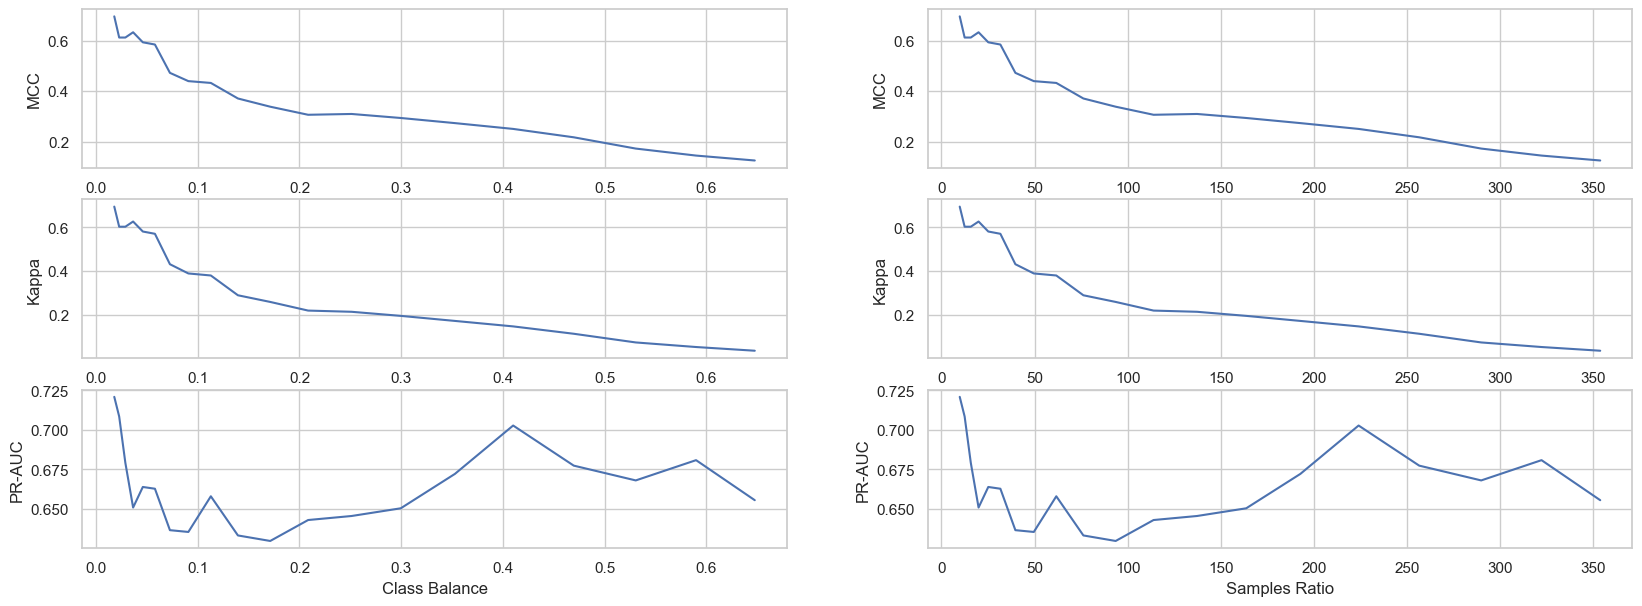

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(20, 7))

sns.lineplot(outp, x='Class Balance', y='MCC', ax=ax[0][0])
sns.lineplot(outp, x='Samples Ratio', y='MCC', ax=ax[0][1])

sns.lineplot(outp, x='Class Balance', y='Kappa', ax=ax[1][0])
sns.lineplot(outp, x='Samples Ratio', y='Kappa', ax=ax[1][1])

sns.lineplot(outp, x='Class Balance', y='PR-AUC', ax=ax[2][0])
sns.lineplot(outp, x='Samples Ratio', y='PR-AUC', ax=ax[2][1])

plt.show()

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [31]:
from imblearn.under_sampling import NearMiss

neighb = np.arange(1, 20)

outp_NearMiss = pd.DataFrame()

for i, b in enumerate(balance):

    X_train_sample, y_train_sample = NearMiss(sampling_strategy={0: int(b * df_train.shape[0])}).fit_resample(df_train.drop('Class', axis=1), df_train['Class'])

    pred = CatBoostClassifier(verbose=False).fit(X_train_sample, y_train_sample).predict(df_test.drop('Class', axis=1))

    kp = kappa(df_test['Class'].values, pred)
    mcc_score = mcc(df_test['Class'].values, pred)
    pr = average_precision_score(df_test['Class'].values, pred)

    outp_NearMiss.loc[i, ['Class Balance', 'Samples Ratio', 'Kappa', 'MCC', 'PR-AUC']] = [y_train_sample.mean(), df_train.shape[0] / X_train_sample.shape[0], kp, mcc_score, pr]

for i, n in enumerate(neighb):

    X_train_sample, y_train_sample = NearMiss(n_neighbors=n).fit_resample(df_train.drop('Class', axis=1), df_train['Class'])


    model = CatBoostClassifier(verbose=False).fit(X_train_sample, y_train_sample)
    pred = model.predict(df_test.drop('Class', axis=1))
    pred_proba = model.predict_proba(df_test.drop('Class', axis=1))[:, 1]

    kp = kappa(df_test['Class'].values, pred)
    mcc_score = mcc(df_test['Class'].values, pred)
    ap_score = average_precision_score(df_test['Class'].values, pred_proba)

    outp_NearMiss.loc[i, ['Neighbours','Kappa_N', 'MCC_N', 'PR-AUC_N']] = [n, kp, mcc_score, ap_score]

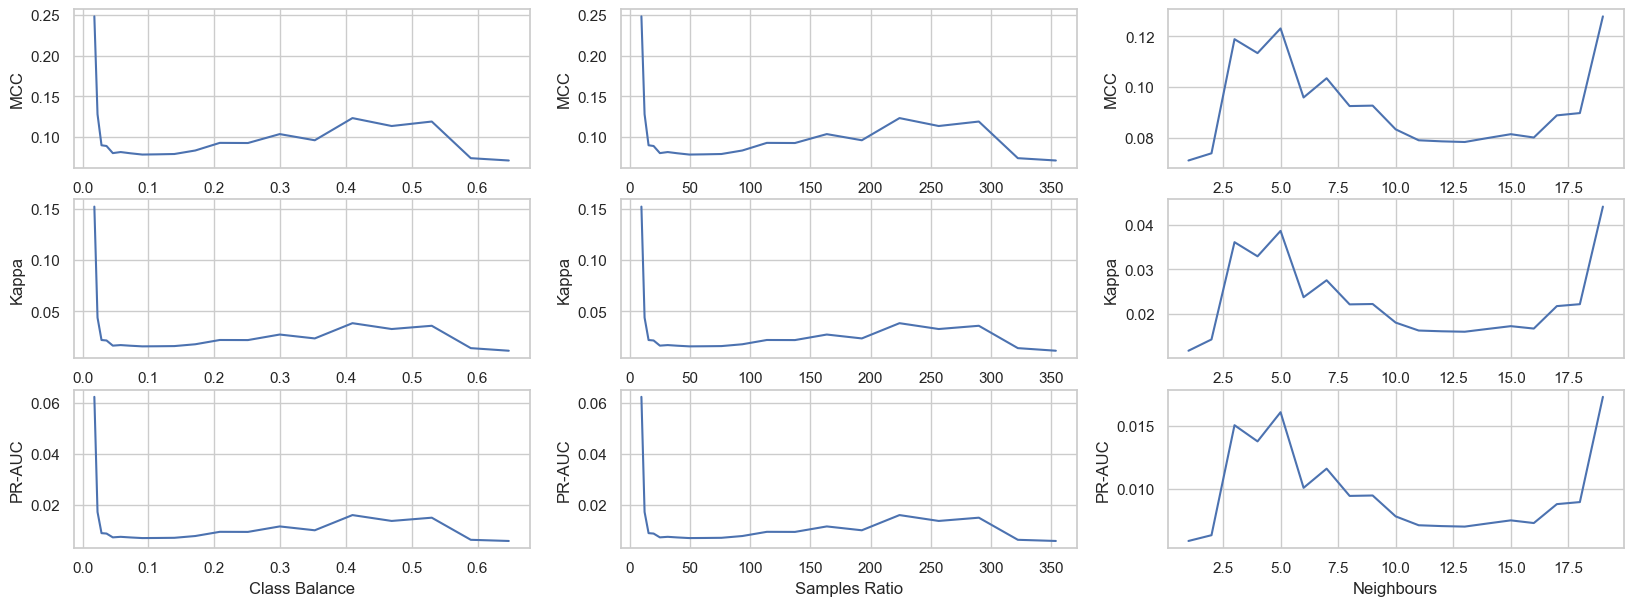

In [32]:
fig, ax = plt.subplots(3, 3, figsize=(20, 7))

sns.lineplot(outp_NearMiss, x='Class Balance', y='MCC', ax=ax[0][0])
sns.lineplot(outp_NearMiss, x='Samples Ratio', y='MCC', ax=ax[0][1])
sns.lineplot(outp_NearMiss, x='Neighbours', y='MCC', ax=ax[0][2])

sns.lineplot(outp_NearMiss, x='Class Balance', y='Kappa', ax=ax[1][0])
sns.lineplot(outp_NearMiss, x='Samples Ratio', y='Kappa', ax=ax[1][1])
sns.lineplot(outp_NearMiss, x='Neighbours', y='Kappa', ax=ax[1][2])

sns.lineplot(outp_NearMiss, x='Class Balance', y='PR-AUC', ax=ax[2][0])
sns.lineplot(outp_NearMiss, x='Samples Ratio', y='PR-AUC', ax=ax[2][1])
sns.lineplot(outp_NearMiss, x='Neighbours', y='PR-AUC', ax=ax[2][2])

plt.show()

> #### Попробуем для зафиксированного количества соседей нарисовать графики для <code>MCC</code> и <code>Kappa</code> в зависимости от баланса классов

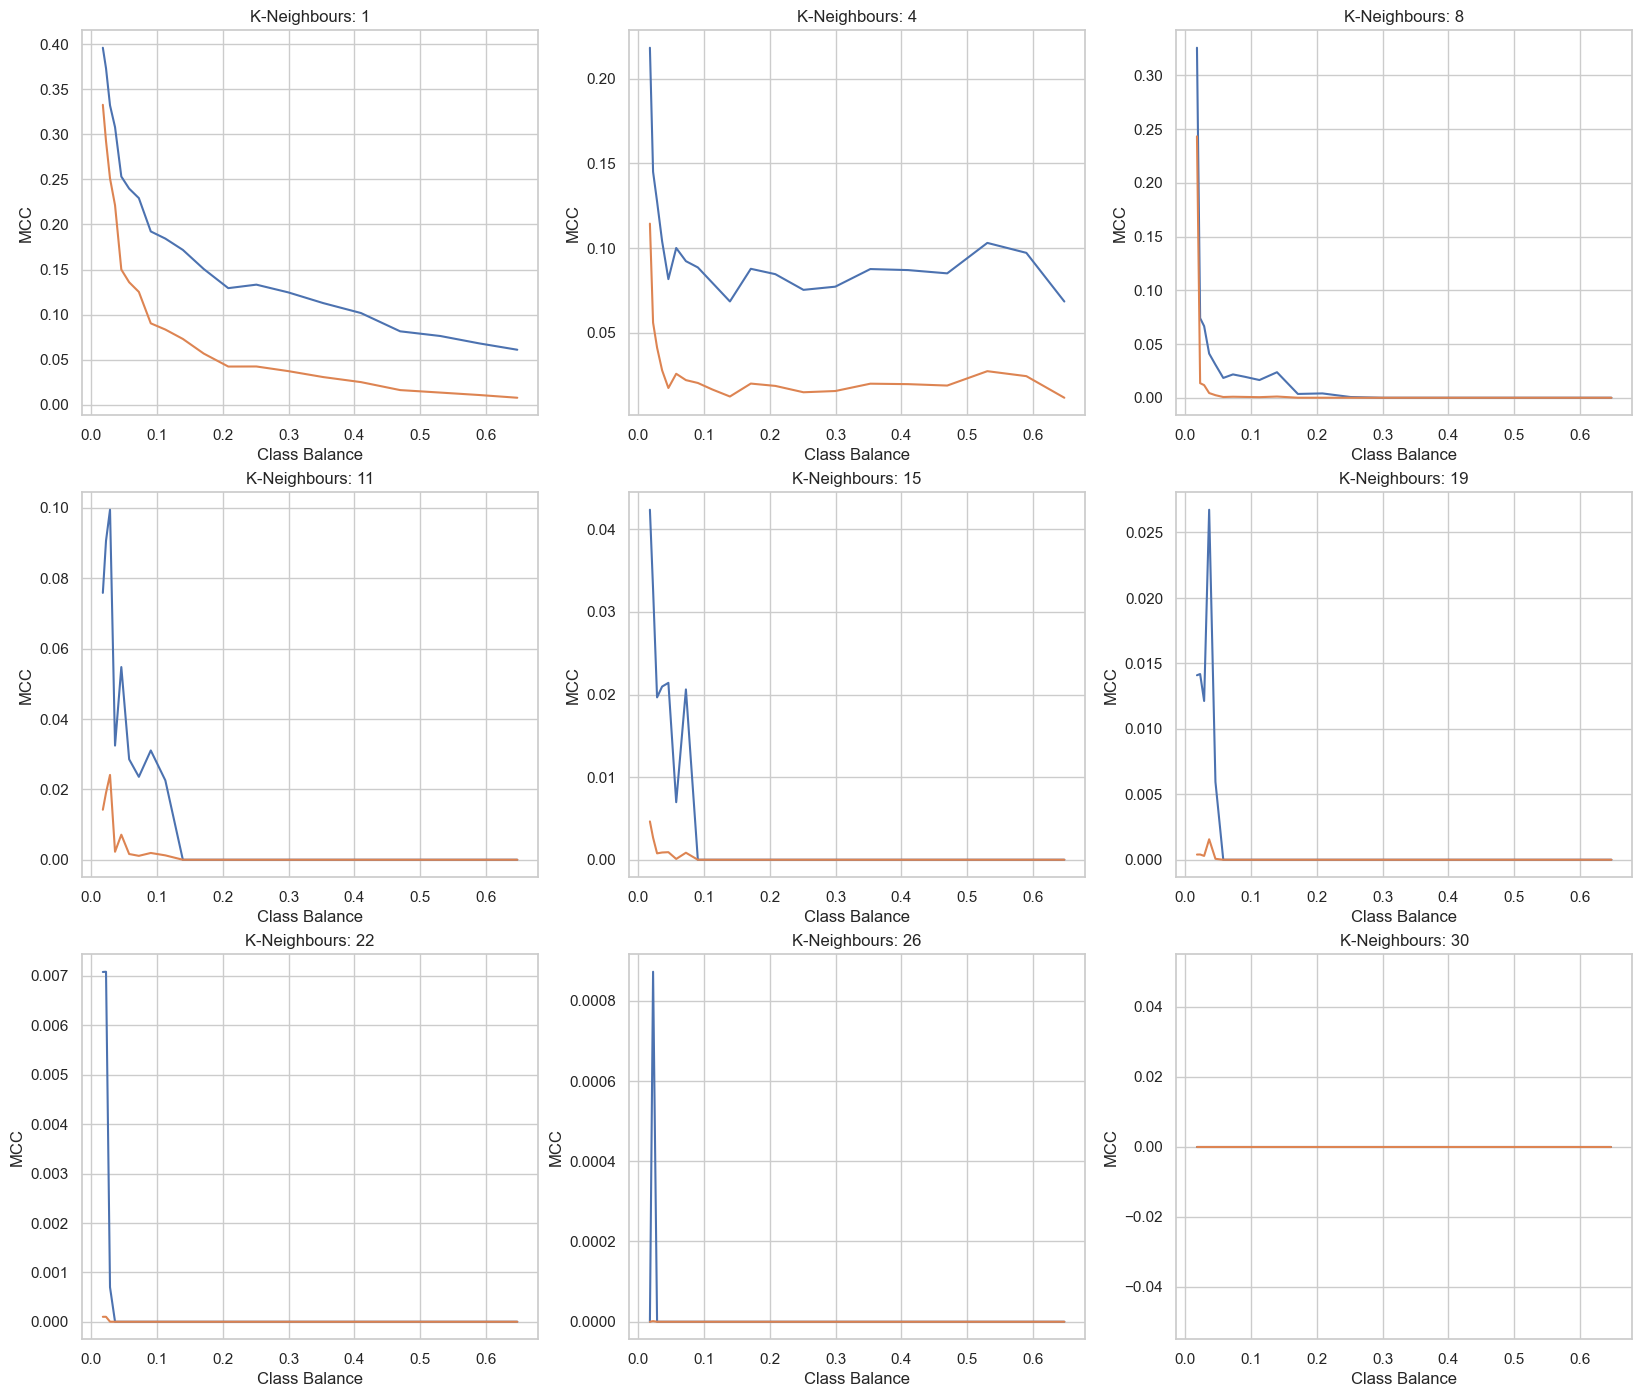

In [33]:
fig, ax = plt.subplots(3, 3, figsize=(20, 17))


for i, nbs in enumerate(np.linspace(1, 30, 9).astype(int)):

    otp = pd.DataFrame()

    for j, b in enumerate(balance):

        X_train_sample, y_train_sample = NearMiss(sampling_strategy={0: int(b * df_train.shape[0])}, n_neighbors=nbs).fit_resample(df_train.drop('Class', axis=1), df_train['Class'])

        model = CatBoostClassifier(verbose=False).fit(X_train_sample, y_train_sample)
        pred = model.predict(df_test.drop('Class', axis=1)) 
        pred_proba = model.predict_proba(df_test.drop('Class', axis=1))[:, 1]

        kp = kappa(df_test['Class'].values, pred)
        mcc_score = mcc(df_test['Class'].values, pred)
        pr = average_precision_score(df_test['Class'].values, pred_proba)

        otp.loc[j, ['Class Balance', 'Samples Ratio', 'Kappa', 'MCC']] = [y_train_sample.mean(), df_train.shape[0] / X_train_sample.shape[0], kp, mcc_score]

    ax[i//3][i%3].set_title(f'K-Neighbours: {nbs}')
    sns.lineplot(otp, x='Class Balance', y='MCC', ax=ax[i//3][i%3])
    sns.lineplot(otp, x='Class Balance', y='Kappa', ax=ax[i//3][i%3])




**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.


> ### **<div style='color:cyan'>AllKNN</div>**
>
> #### AllKNN удаляет лишние примеры из классов большинства, используя <code>KNN</code>, чтобы сбалансировать набор данных, сохраняя наиболее информативные точки

In [79]:
from imblearn.under_sampling import AllKNN

tl = pd.DataFrame()

for i, nb in enumerate(neighb[:4]):

    X_train_sample, y_train_sample = AllKNN(n_neighbors=nb).fit_resample(df_train.drop('Class', axis=1), df_train['Class'])

    model = CatBoostClassifier(verbose=False).fit(X_train_sample, y_train_sample)
    pred = model.predict(df_test.drop('Class', axis=1))
    pred_proba = model.predict_proba(df_test.drop('Class', axis=1))[:, 1]


    kp = kappa(df_test['Class'].values, pred)
    mcc_score = mcc(df_test['Class'].values, pred)
    pr = average_precision_score(df_test['Class'].values, pred_proba)

    tl.loc[i, ['Class Balance', 'Samples Ratio', 'Kappa', 'MCC', 'AP','Neighb']] = [y_train_sample.mean(), df_train.shape[0] / X_train_sample.shape[0], kp, mcc_score, pr, nb]


In [80]:
tl.sort_values(['Kappa', 'MCC', 'AP'], ascending=False).head()

,Class Balance,Samples Ratio,Kappa,MCC,AP,Neighb
2,0.001834,1.001935,0.736671,0.746041,0.713594,3.0
0,0.001831,1.000439,0.736671,0.746041,0.702531,1.0
3,0.001836,1.002905,0.736671,0.746041,0.699164,4.0
1,0.001832,1.001142,0.717759,0.723739,0.691660,2.0


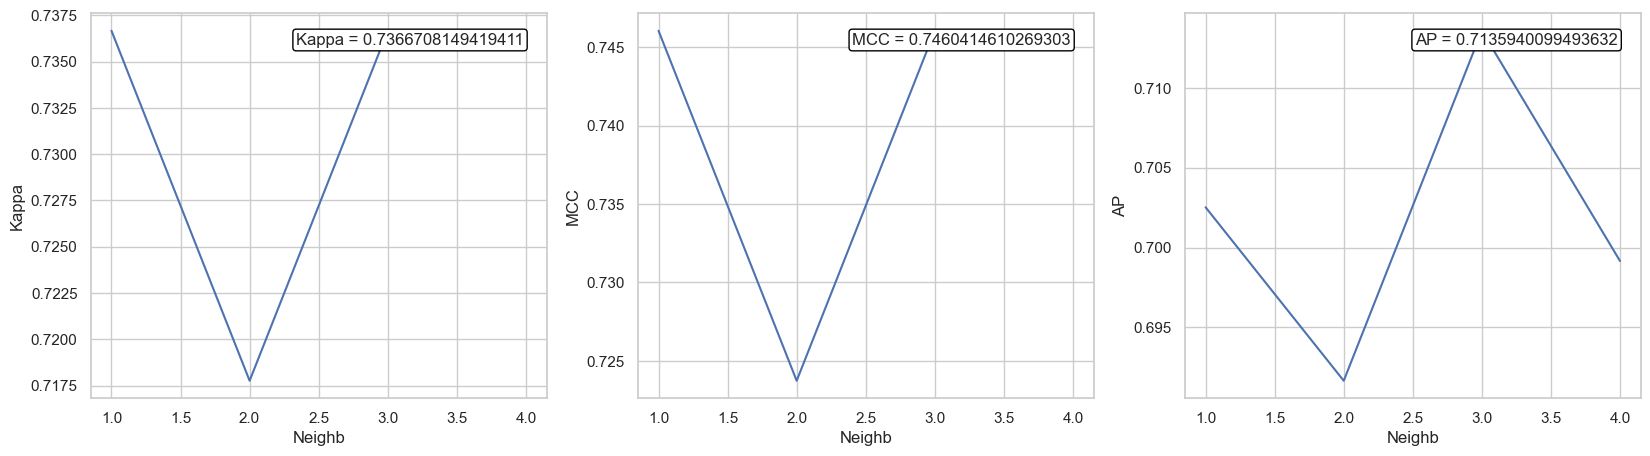

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(tl, x='Neighb', y='Kappa', ax=ax[0])
sns.lineplot(tl, x='Neighb', y='MCC', ax=ax[1])
sns.lineplot(tl, x='Neighb', y='AP', ax=ax[2])


text = ax[0].text(0.95, 0.95, f'Kappa = {tl["Kappa"].max()}', ha="right", va="top", transform=ax[0].transAxes, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round", pad=0.2))
text = ax[1].text(0.95, 0.95, f'MCC = {tl["MCC"].max()}', ha="right", va="top", transform=ax[1].transAxes, bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", pad=0.2))
text = ax[2].text(0.95, 0.95, f'AP = {tl["AP"].max()}', ha="right", va="top", transform=ax[2].transAxes, bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", pad=0.2))


plt.show()

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

In [49]:
import optuna
from optuna.integration import CatBoostPruningCallback
from IPython.display import clear_output

optuna.logging.set_verbosity(optuna.logging.WARNING)

borders = np.linspace(0.1, 0.5, 5)

t = None

def objective(trial):
    # define the hyperparameters for CatBoost
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-1),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 1e-1),
        'border_count': trial.suggest_int('border_count', 16, 255),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'verbose': False
    }

    model = CatBoostClassifier(**params, random_state=42)

    model.fit(df_train.drop('Class', axis=1), df_train['Class'], eval_set=[(df_val.drop('Class', axis=1), df_val['Class'])], verbose=False)

    ap = average_precision_score(df_val['Class'], model.predict_proba(df_val.drop('Class', axis=1))[:, 1])

    return ap

optuna_plus_catboost = pd.DataFrame()

for i, t in enumerate(borders):

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, timeout=600)

    params = study.best_params
    params['verbose'] = False

    X_train, y_train = k_means_smote.fit_resample(df_train.drop('Class', axis=1), df_train['Class'])

    model = CatBoostClassifier(**params).fit(X_train, y_train)
    pred_proba = model.predict_proba(df_test.drop('Class', axis=1))[:, 1]
    pred = pred_proba >= t

    k = kappa(df_test['Class'].values, pred)
    m = mcc(df_test['Class'].values, pred)
    ap = average_precision_score(df_test['Class'].values, pred_proba)

    optuna_plus_catboost.loc[i, ['Kappa', 'MCC', 'AP', 't', 'params']] = [k, m, ap, t, study.best_params]

    clear_output()
    display(optuna_plus_catboost.sort_values(['Kappa', 'MCC', 'AP'], ascending=False))


,Kappa,MCC,AP,t,params
3,0.780331,0.782431,0.732022,0.185714,"{'learning_rate': 0.02289285056949431, 'depth'..."
4,0.780331,0.782431,0.710739,0.214286,"{'learning_rate': 0.05706804157016948, 'depth'..."
6,0.780331,0.782431,0.702148,0.271429,"{'learning_rate': 0.024974539892533856, 'depth..."
7,0.769075,0.775483,0.719941,0.300000,"{'learning_rate': 0.16877069874519995, 'depth'..."
0,0.761729,0.762596,0.711298,0.100000,"{'learning_rate': 0.013684646083079472, 'depth..."
5,0.761729,0.762596,0.700251,0.242857,"{'learning_rate': 0.011207185809197247, 'depth..."
1,0.652766,0.656197,0.721643,0.128571,"{'learning_rate': 0.058365552748947794, 'depth..."
2,0.515646,0.538905,0.539761,0.157143,"{'learning_rate': 0.02868234680167888, 'depth'..."


Training has stopped (degenerate solution on iteration 29, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 9, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 36, probably too small l2-regularization, try to increase it)
[W 2024-05-17 17:09:31,216] Trial 49 failed with parameters: {'learning_rate': 0.032423031913727196, 'depth': 6, 'l2_leaf_reg': 0.023230336140486703, 'random_strength': 0.003004524100937651, 'border_count': 198, 'iterations': 792} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/k6/1s3wy1bd30n_wlt4trds7drh0000gn/T/ipykernel_1298/1217126083.py", line 25, in objective
    model.f

KeyboardInterrupt: 

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [51]:
from joblib import Parallel, delayed, cpu_count
import time

def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """

    return 2 * (np.log(n - 1) + 0.5772156649) - 2 * (n-1)/n if n > 1 else 0

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """

    if node.kind == 'external':

        return depth + c_factor(node.size)
    
    return calc_height(X, depth + 1, node.left) if (X - node.b) @ node.w <= 0 else calc_height(X, depth + 1, node.right)


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """

    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        

        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """

        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """

    def __init__(self, X, max_depth, level):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """

        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.level = level

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """

        if depth >= self.max_depth or len(X) <= 1:

            self.external_count += 1

            return Node(X, depth, None, None, 'external', None, None)
        
        self.internal_count += 1

        ind_to_remove = np.random.choice(np.arange(X.shape[1]), (X.shape[1] - 1) - self.level, replace = False)

        n = np.random.normal(0, 1, X.shape[1])
        p = np.random.uniform(X.min(axis=0), X.max(axis=0))

        n[ind_to_remove] = 0
            
        return Node(X, depth, self.grow(X[(X - p) @ n <= 0], depth + 1), self.grow(X[(X - p) @ n > 0], depth + 1), 'internal', n, p)


    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """

        scores = np.apply_along_axis(lambda x: calc_height(x, 0, self.root), 1, X)

        return scores
        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """

    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01, level = 0):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """

    
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.level = level
        self.is_fit = False
        
    def __repr__(self):
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit_slowed(self, X):
        sub = int(self.subsample_rate * X.shape[0])
        idc = np.arange(X.shape[0])
        trees = [RandomizedTree(X[np.random.choice(idc, sub, replace=False), :], self.max_depth, self.level) for i in range(self.n_trees)]
        return self

    
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
         
        self.subsamp = int(self.subsample_rate * X.shape[0])

        self.l = X.shape[0]
        idc = np.arange(X.shape[0])

        self.trees = Parallel(n_jobs=cpu_count())([delayed(RandomizedTree)(X[np.random.choice(idc, self.subsamp, replace=False), :], self.max_depth, self.level) for i in range(self.n_trees)])

        return self
    
    def score_samples_slowed(self, X):

        preds = np.array([self.trees[i].score_samples(X) for i in range(len(self.trees))]).mean(axis=0)
        scores = 2.0 ** (-preds / c_factor(self.l))
        
        
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """

        preds = np.array(Parallel(n_jobs=cpu_count())([delayed(self.trees[i].score_samples)(X) for i in range(len(self.trees))])).mean(axis=0)

        scores = 2.0 ** (-preds / c_factor(self.subsamp))

        return scores
    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """

        probs = self.score_samples(X)

        t = np.quantile(probs, 1 - self.contamination)

        return probs >= t
    
    #### SUMMARY ####

    def plot_summary(self, fast_fit, fast_pred, slow_fit, slow_pred):

        print('#'*(28 + len('Comparison')))
        print('##' + ' '* 12 + 'Comparison' + ' ' * 12 + '##')
        print('#'*(28 + len('Comparison')))
        print('# Parallel' + ' '*27 + '#')
        print('#' + ' '*36 + '#')
        print(f'# Fit: {round(fast_fit, 3)} sec' + ' '*(26 - len(str(round(fast_fit, 3)))) + '#')
        print(f'# Predict: {round(fast_pred, 3)} sec' + ' '*(22 - len(str(round(fast_pred, 3)))) + '#')
        print('#'*(28 + len('Comparison')))
        print('# Using loop' + ' '*25 + '#')
        print('#' + ' '*36 + '#')
        print(f'# Fit: {round(slow_fit, 3)} sec' + ' '*(26 - len(str(round(slow_fit, 3)))) + '#')
        print(f'# Predict: {round(slow_pred, 3)} sec' + ' '*(22 - len(str(round(slow_pred, 3)))) + '#')
        print('#'*(28 + len('Comparison')))
    
    def compare_time(self, X):

        start = time.time()
        self.fit(X)
        time_1 = time.time() - start

        start = time.time()
        self.score_samples(X)
        time_2 = time.time() - start

        start = time.time()
        self.fit_slowed(X)
        time_3 = time.time() - start

        start = time.time()
        self.score_samples_slowed(X)
        time_4 = time.time() - start

        self.plot_summary(time_1, time_2, time_3, time_4)

> #### Убедимся, что распараллеливание действительно помогло ускорить процесс обучения и предсказания модели

In [52]:
ExtendedIsolationForest(50, 0.5, 12, 0.01).fit(df_train.drop('Class', axis=1).values).compare_time(df_train.drop('Class', axis=1).values)

######################################
##            Comparison            ##
######################################
# Parallel                           #
#                                    #
# Fit: 8.258 sec                     #
# Predict: 37.28 sec                 #
######################################
# Using loop                         #
#                                    #
# Fit: 14.416 sec                    #
# Predict: 139.652 sec               #
######################################


> #### В статье указано, что можно из <code>ExtendedIsolationForest</code> можно сделать переход в обычный <code>IsolationForest</code> за счет зануления параметра <code>level</code>. Зануление данного параметра приводит к занулению угла наклона гиперплоскостей. В коде это было реализовано, параметр <code>self.level</code>

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [53]:
import optuna
from sklearn.metrics import average_precision_score

optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):

    feature_size = df.shape[1]
    
    params = {
        'n_trees': trial.suggest_int('n_trees', 5, 50),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'subsample_rate': trial.suggest_float('subsample_rate', 0.001, 1),
        'contamination': trial.suggest_float('contamination', 0.001, 1),
        'level': trial.suggest_int('level', 1, feature_size - 2)
    }


    model = ExtendedIsolationForest(**params)

    model.fit(df.drop('Class', axis=1).values)

    ap = average_precision_score(df_val['Class'], model.score_samples(df_val.drop('Class', axis=1).values))

    return ap

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)

In [54]:
eif = ExtendedIsolationForest(**study.best_params)

eif.fit(df.drop('Class', axis=1).values)

print(f'Коэффициент Каппа Коэна на test: {kappa(df_test["Class"].values, eif.predict(df_test.drop("Class", axis=1).values))}')
print(f'MCC на test: {mcc(df_test["Class"].values, eif.predict(df_test.drop("Class", axis=1).values))}')
print(f'PR-AUC на test: {average_precision_score(df_test["Class"].values, eif.score_samples(df_test.drop("Class", axis=1).values))}', '\n')

Коэффициент Каппа Коэна на test: 0.0008568898749170557
MCC на test: 0.02070334710147577
PR-AUC на test: 0.04813178484238027 



> #### Удалим несколько параметров из <code>ExtendedIsolationForest</code>, которые не подходят для <code>IsolationForest</code>, и замерим качество

In [57]:
from sklearn.ensemble import IsolationForest

new_best_params = study.best_params
new_best_params['n_estimators'] = study.best_params['n_trees']
new_best_params['n_estimators'] = study.best_params['n_trees']
del new_best_params['n_trees']
del new_best_params['max_depth']
del new_best_params['subsample_rate']
del new_best_params['level']
del new_best_params['contamination']

isolFor = IsolationForest(**new_best_params).fit(df_train.drop('Class', axis=1))

pred_proba = isolFor.decision_function(df_test.drop('Class', axis=1))
pred = isolFor.predict(df_test.drop('Class', axis=1))
pred = np.array([1 if x == -1 else 0 for x in pred])

print(f'Коэффициент Каппа Коэна на test: {kappa(df_test["Class"].values, pred)}')
print(f'MCC на test: {mcc(df_test["Class"].values, pred)}')
print(f'PR-AUC на test: {average_precision_score(df_test["Class"].values, pred_proba)}', '\n')

Коэффициент Каппа Коэна на test: 0.026976342975286893
MCC на test: 0.10235334060089195
PR-AUC на test: 0.0004179042725571575 



> #### Чтобы из <code>ExtendedIsolationForest</code> сделать обычный <code>IsolationForest</code> необходимо занулить параметр <code>level</code>, что позволит строить разделяющие гиперплоскости параллельно 

In [59]:
from sklearn.ensemble import IsolationForest

params = {'n_estimators': study.best_params['n_trees'],
          'contamination': study.best_params['contamination'],
          'max_samples': study.best_params['subsample_rate']
          }

ifclf = IsolationForest()
ifclf.fit(df_train.drop('Class', axis=1))

print(f'Коэффициент Каппа Коэна на test: {kappa(df_test["Class"].values, ifclf.predict(df_test.drop("Class", axis=1).values))}')
print(f'MCC на test: {mcc(df_test["Class"].values, ifclf.predict(df_test.drop("Class", axis=1).values))}')
print(f'PR-AUC на test: {average_precision_score(df_test["Class"].values, ifclf.predict(df_test.drop("Class", axis=1).values))}', '\n')

Коэффициент Каппа Коэна на test: -0.00056400094208036
MCC на test: 0
PR-AUC на test: 0.0006385859815447563 



Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

eif = ExtendedIsolationForest(**study.best_params).fit(df_train.drop('Class', axis=1).values)

df_check = pd.DataFrame(pca.fit_transform(df_train))
df_check['Pred'] = eif.predict(df_train.drop('Class', axis=1))
df_check['Pred_Prob'] = eif.score_samples(df_train.drop('Class', axis=1))
df_check['Pred_Prob'] = df_check['Pred_Prob'].apply(lambda x: 1 if x == np.inf else x)
df_check['True'] = df_train['Class']



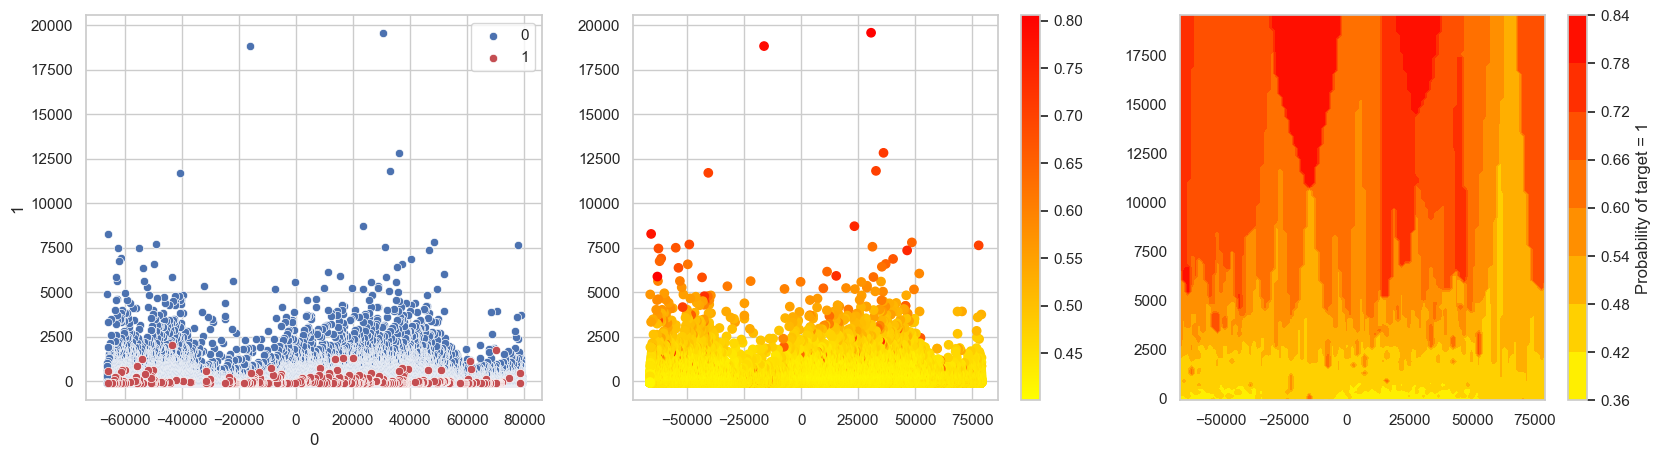

In [61]:
from scipy.interpolate import griddata

def plot_heatmap(X, probs, ax):

    grid_size = 100

    xmin, xmax = X[:, 0].min(), X[:, 0].max()
    ymin, ymax = X[:, 1].min(), X[:, 1].max()

    x = np.linspace(xmin, xmax, grid_size)
    y = np.linspace(ymin, ymax, grid_size)
    xx, yy = np.meshgrid(x, y)
    X_grid = np.vstack((xx.ravel(), yy.ravel())).T

    probs_grid = griddata(X, probs, X_grid, method='nearest').reshape(grid_size, grid_size)

    contour = ax.contourf(xx, yy, probs_grid, cmap='autumn_r')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    cbar = fig.colorbar(contour)
    cbar.set_label('Probability of target = 1')

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.scatterplot(df_check[df_check['True'] == 0], x=0, y=1, label='0', ax=ax[0])
sns.scatterplot(df_check[df_check['True'] == 1], x=0, y=1, c='r', label='1', ax=ax[0])
ax[0].legend()

probs = eif.score_samples(df_train.drop('Class', axis=1).values)

ax[1].scatter(df_check[0].values, df_check[1].values, c=probs, cmap='autumn_r')
fig.colorbar(ax[1].collections[0], ax=ax[1])


plot_heatmap(df_check[[0, 1]].values, probs, ax[2]);

> #### Ориентируясь на график после применения <code>PCA</code> довольно сложно сделать выводы, но на графике с вероятностями видно, что модели удается найти как достаточно легкие объекты (которые находятся достаточно далеко относительно скопления точек), так и выявить выбросы из массы объектов. Так, можно на графике увидеть, что среди объектов с маленьким значением <code>ScoreSamples</code> выделяются точки с большими значениями. Но, к сожалению, выделяются не все точки, а лишь малая часть

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [62]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

lof = LocalOutlierFactor(novelty=True).fit(df_train.drop('Class', axis=1), df_train['Class'])
ocsvm = OneClassSVM().fit(df_train.drop('Class', axis=1), df_train['Class'])

In [63]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

pred_lof = lof.predict(df_test.drop("Class", axis=1).values)
pred_svm = ocsvm.predict(df_test.drop("Class", axis=1).values)

print(f'Коэффициент Каппа Коэна на test (LOF): {kappa(df_test["Class"].values, pred_lof)}')
print(f'MCC на test (LOF): {mcc(df_test["Class"].values, pred_lof)}')
print(f'PR-AUC на test (LOF): {average_precision_score(df_test["Class"].values, pred_lof)}', '\n')

print(f'Коэффициент Каппа Коэна на test (OCSVM): {kappa(df_test["Class"].values, pred_svm)}')
print(f'MCC на test (OCSVM): {mcc(df_test["Class"].values, pred_svm)}')
print(f'PR-AUC на test (OCSVM): {average_precision_score(df_test["Class"].values, pred_svm)}', '\n')

Коэффициент Каппа Коэна на test (LOF): 0.0
MCC на test (LOF): 0
PR-AUC на test (LOF): 0.000772444787753239 

Коэффициент Каппа Коэна на test (OCSVM): 0.0
MCC на test (OCSVM): 0
PR-AUC на test (OCSVM): 0.000772444787753239 



У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [74]:
train_ocsvm, test_ocsvm = ocsvm.score_samples(df_train.drop('Class', axis=1)), ocsvm.score_samples(df_test.drop('Class', axis=1))
train_lof, test_lof = lof.score_samples(df_train.drop('Class', axis=1)), lof.score_samples(df_test.drop('Class', axis=1))
train_if, test_if = ifclf.score_samples(df_train.drop('Class', axis=1)), ifclf.score_samples(df_test.drop('Class', axis=1))
train_eif, test_eif = eif.score_samples(df_train.drop('Class', axis=1)), eif.score_samples(df_test.drop('Class', axis=1))

df_train_mod = df_train.copy()
df_test_mod = df_test.copy()


df_train_mod['OCSVM'], df_train_mod['LOF'], df_train_mod['IF'], df_train_mod['EIF'] = [train_ocsvm, train_lof, train_if, train_eif]
df_test_mod['OCSVM'], df_test_mod['LOF'], df_test_mod['IF'], df_test_mod['EIF'] = [test_ocsvm, test_lof, test_if, test_eif]

> #### У меня забылись оптимальные параметры, поэтому я заново запустил оптуну и использую уже оптимальное значение порога

In [83]:
import optuna
from optuna.integration import CatBoostPruningCallback
from IPython.display import clear_output

optuna.logging.set_verbosity(optuna.logging.WARNING)

borders = np.linspace(0.1, 0.5, 5)

t = None

def objective(trial):
    # define the hyperparameters for CatBoost
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-1),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 1e-1),
        'border_count': trial.suggest_int('border_count', 16, 255),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'verbose': False
    }

    model = CatBoostClassifier(**params, random_state=42)

    model.fit(df_train.drop('Class', axis=1), df_train['Class'], eval_set=[(df_val.drop('Class', axis=1), df_val['Class'])], verbose=False)

    ap = average_precision_score(df_val['Class'], model.predict_proba(df_val.drop('Class', axis=1))[:, 1])

    return ap


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)

params = study.best_params
params['verbose'] = False

Training has stopped (degenerate solution on iteration 15, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 7, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 9, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 12, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 84, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 91, probably too small l2-regularization, try to increase it)


In [91]:
otp = pd.DataFrame()

X_train, y_train = KMeansSMOTE(**k_means_smote_best_params).fit_resample(df_train_mod.drop('Class', axis=1), df_train_mod['Class'])

model = CatBoostClassifier(**params).fit(X_train, y_train)
pred_proba = model.predict_proba(df_test_mod.drop('Class', axis=1))[:, 1]
pred = pred_proba >= 0.185714

k = kappa(df_test_mod['Class'].values, pred)
m = mcc(df_test_mod['Class'].values, pred)
ap = average_precision_score(df_test_mod['Class'].values, pred_proba)

otp.loc[i, ['Kappa', 'MCC', 'AP', 't', 'params']] = [k, m, ap, 0.185714, study.best_params]

otp

,Kappa,MCC,AP,t,params
3,0.727062,0.727062,0.683634,0.185714,"{'learning_rate': 0.042525633378126516, 'depth..."


> #### Данный метод не смог превзойти лучшую модель. Это может быть связано с тем, что я не запускал оптуну на новом датасете и лучшие параметры из предыдущего задания не являются оптимальными конкретного для данного случая

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: <code>НЕЕТ</code>

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [ ]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

0.6723893615619416